In this project, we will be exploring chinook database and delve into interesting business questions and answer them using SQL.

In [13]:
# importing libraries and loading the database
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

db = 'chinook.db'

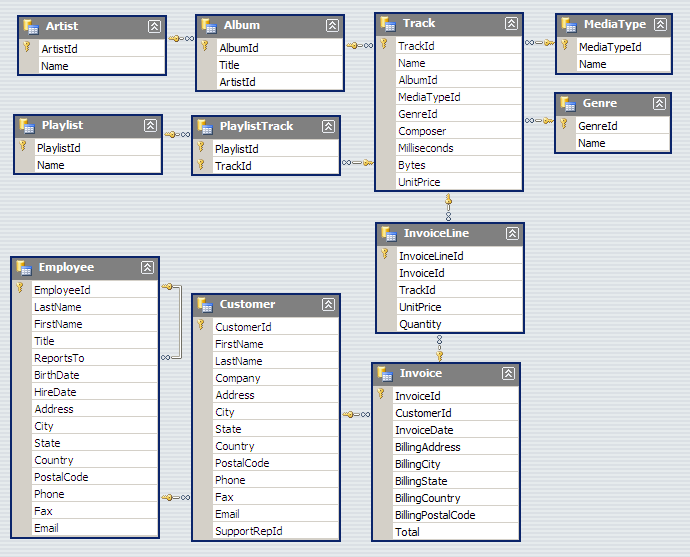

In [6]:
# Schema
from IPython.display import Image
Image("schema.png")

In [3]:
# creating helper functions to execute queries and return them as pandas dataframes
def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)

def run_command(c):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(c)

def show_tables():
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    return run_query(q)

In [7]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


# Evaluating Sales by Genre 

Let us start of by considering genre. Information about sales by genre would be helpful to determine which albums to add to their store. For instance lets say that the company is considering albums from the following list of artists:
1) Regal (hip-hop)
2) Red Tone (punk)
3) Slim Jim Bites (blues)
4) Meteor and the Girls (pop)

In [15]:
query1 = '''
WITH usa_tracks_sold AS
   (
    SELECT il.* FROM invoice_line il
    INNER JOIN invoice i on il.invoice_id = i.invoice_id
    INNER JOIN customer c on i.customer_id = c.customer_id
    WHERE c.country = "USA"
   )

SELECT
    g.name Genre,
    count(uts.invoice_line_id) Tracks_sold,
    cast(count(uts.invoice_line_id) AS FLOAT) / (
        SELECT COUNT(*) from usa_tracks_sold
    ) Percentage
FROM usa_tracks_sold uts
INNER JOIN track t on t.track_id = uts.track_id
INNER JOIN genre g on g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10;
'''

genre_sales=run_query(query1)
genre_sales

,Genre,Tracks_sold,Percentage
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


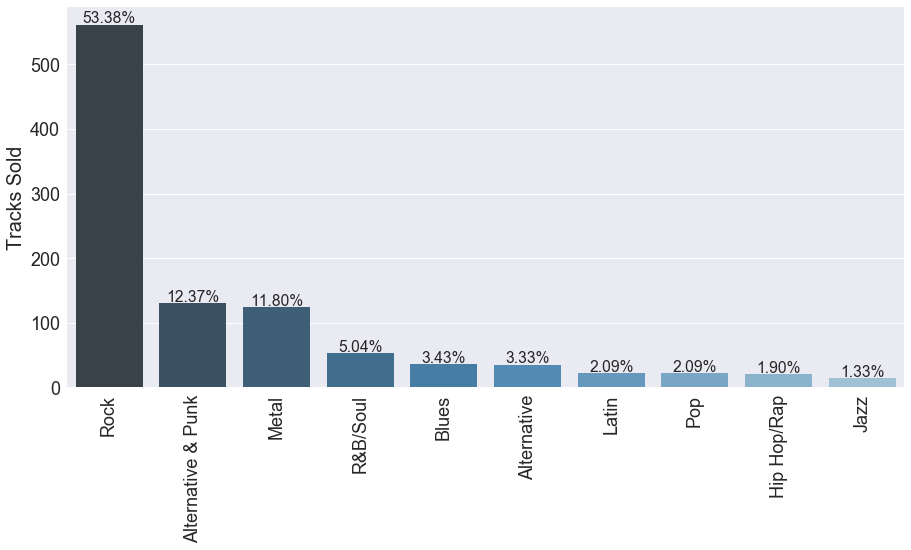

In [18]:
sns.set_style("whitegrid")
sns.set(font_scale=1.8)

fig = plt.figure(figsize=(15,7))
ax = sns.barplot(x="Genre", y="Tracks_sold", data=genre_sales, palette="Blues_d")
ax.set_xticklabels(genre_sales['Genre'], rotation=90)
percent_labels = genre_sales['Percentage']
ax.set_xlabel('')
ax.set_ylabel('Tracks Sold')


sns.set(font_scale=1.3)

#Labels each bar with the percentage of sales.
for i in range(len(ax.patches)):
    p = ax.patches[i]
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(percent_labels.iloc[i]*100)+'%',
            ha="center") 
plt.show()

Based on the sales data across different genres, we can purchase albums from Red Tone (punk).
It is highly advisable to lookout for albums in the "Rock" genre.

# Analyzing Employee Performance
Each customer is assigned a sales support agent in the company when they make a purchase. We can analyze the sales of each employee to see if any of them are underperforming.

In [24]:
query2 = '''
WITH customer_support_rep_sales AS
    (
     SELECT
         i.customer_id,
         c.support_rep_id,
         SUM(i.total) total
     FROM invoice i
     INNER JOIN customer c ON i.customer_id = c.customer_id
     GROUP BY 1,2
    )

SELECT
    e.first_name || " " || e.last_name Employee,
    e.hire_date,
    SUM(csrs.total) Total_sales
FROM customer_support_rep_sales csrs
INNER JOIN employee e ON e.employee_id = csrs.support_rep_id
GROUP BY 1;
'''

employee_sales=run_query(query2)
employee_sales

,Employee,hire_date,Total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


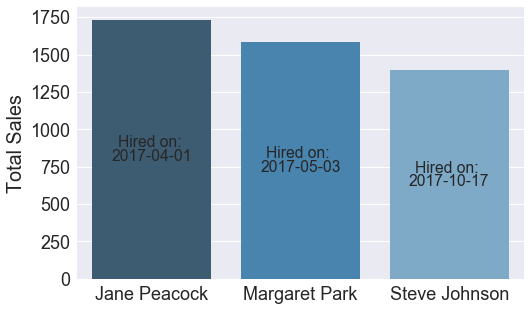

In [29]:
sns.set(font_scale=1.8)
fig = plt.figure(figsize=(8,5))
ax = sns.barplot(x="Employee", y="Total_sales", data=employee_sales, palette="Blues_d")
ax.set_xticklabels(employee_sales['Employee'])
ax.set_xlabel('')
ax.set_ylabel('Total Sales')

#Labels each bar with the percentage of sales.
sns.set(font_scale=1.3)
percent_labels = employee_sales['hire_date'].apply(lambda x: x.split(' ')[0])
for i in range(len(ax.patches)):
    p = ax.patches[i]
    height = p.get_height()/2
    ax.text(p.get_x()+p.get_width()/2.,
            height + 15,
            'Hired on: ',
            ha="center") 
    ax.text(p.get_x()+p.get_width()/2.,
            height - 75,
            (percent_labels.iloc[i]),
            ha="center") 
plt.show()

Jane has the highest sales while Steve has the lowest sales. However, this difference in sales barely corresponds with the difference in their hiring dates.

# Analyzing Sales By Country
Suppose that our companies are considering advertising sales in different countries. We can compute the average value for each country to figure out the best countries to advertise in.

In [34]:
query3 = '''
WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )

SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (
    SELECT
        country,
        count(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(distinct customer_id) customer_lifetime_value,
        SUM(unit_price) / count(distinct invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );
'''

country_sales=run_query(query3)
country_sales

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


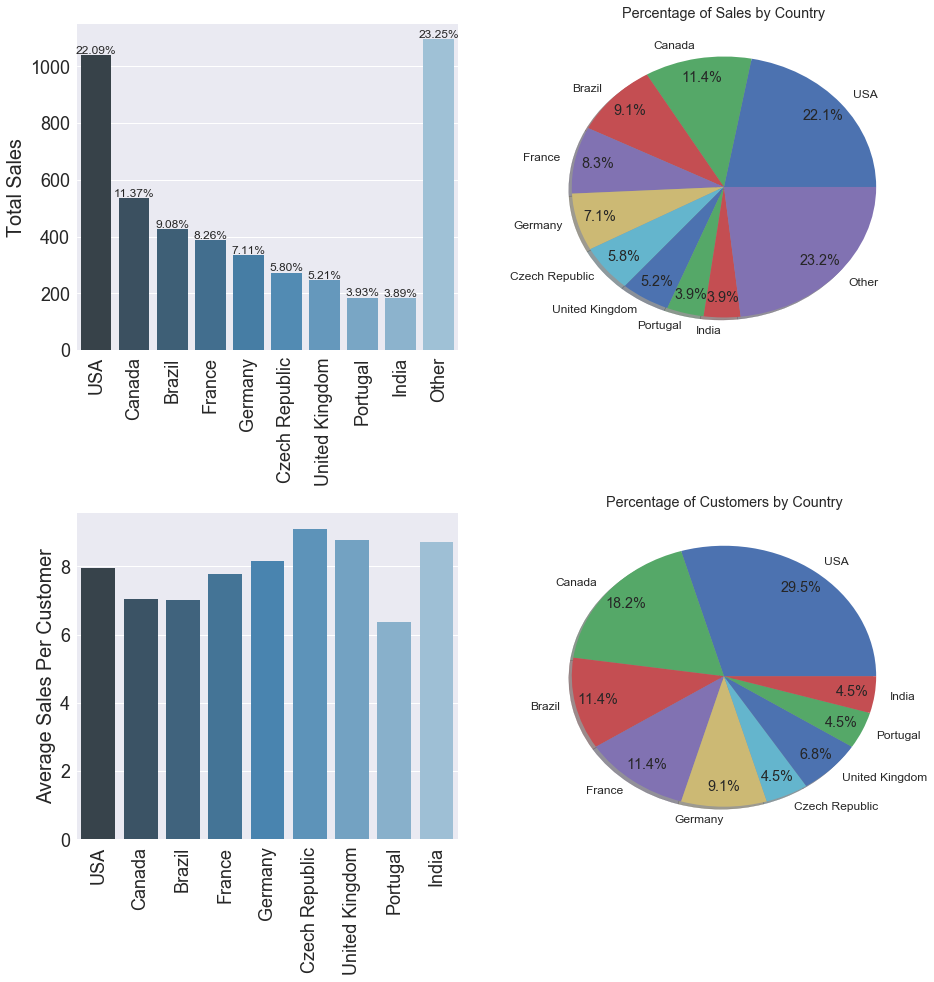

In [41]:
# Sales plot
sales_include_other = country_sales.loc[0:9]
sns.set(font_scale=1.8)
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(2, 2, 1)
ax = sns.barplot(x="country", y="total_sales", data=sales_include_other, palette="Blues_d")
ax.set_xticklabels(sales_include_other['country'], rotation=90)
ax.set_xlabel('')
ax.set_ylabel('Total Sales')

#percentage labels
sns.set(font_scale=1.0)
percent_labels = sales_include_other['total_sales']/sales_include_other['total_sales'].sum()
for i in range(len(ax.patches)):
    p = ax.patches[i]
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2,
            height + 5,
            '{:1.2f}'.format(percent_labels.iloc[i]*100)+'%',
            ha="center")
    
    
#Pie chart 
sns.set(font_scale=1.2)
fig.subplots_adjust(hspace=.5)    
ax2 = fig.add_subplot(2, 2, 2)
ax2 = plt.pie(percent_labels, labels=sales_include_other["country"], autopct='%1.1f%%', shadow=True, pctdistance = 0.85)
plt.title('Percentage of Sales by Country')

#Average customer value plot
sales_exclude_other = country_sales.loc[0:8]
sns.set(font_scale=1.8)
ax3 = fig.add_subplot(2, 2, 3)
ax3 = sns.barplot(x="country", y="average_order", data=sales_exclude_other, palette='Blues_d')
ax3.set_xticklabels(sales_exclude_other['country'], rotation=90)
ax3.set_xlabel('')
ax3.set_ylabel('Average Sales Per Customer')


#Generate the bottom pie chart
sns.set(font_scale=1.2)
percent_labels = sales_exclude_other['customers']/sales_exclude_other['customers'].sum()
ax4 = fig.add_subplot(2, 2, 4)
ax4 = plt.pie(percent_labels, labels=sales_exclude_other["country"], autopct='%1.1f%%', shadow=True, pctdistance = 0.85)
plt.title('Percentage of Customers by Country')

plt.show()

Based on the information above, there are potential advertising opportunities in India, UK and Czech Republic. Each of these countries have a customer base ranging from 4.5-6.8% and total sales percentage ranging from 3.9-5.8%. However, on an average they have the highest spending customers. Marketting efforts can be focused in these countries.

# Analyzing Album and Track sales
It would be useful to analyze sales of individual tracks and albums. If majority customers purchase select tracks, it would mean a loss in terms of album sales. We will be exploring this trend which would facilitate decisions such as promoting album sales at discounted prices or increasing the pricing of individual tracks.

In [43]:
query4 = '''WITH invoice_detailed AS
    (SELECT
        t.track_id,
        i.invoice_id,
        (i.total) total
    FROM
        track t
    INNER JOIN invoice_line il ON il.track_id = t.track_id
    INNER JOIN invoice i ON i.invoice_id = il.invoice_id
    GROUP BY i.invoice_id
    )
    
SELECT
    album_purchase,
    COUNT(*) number_of_invoices,
    CAST (COUNT(*) AS FLOAT)/(SELECT COUNT(invoice_id) FROM invoice_detailed) AS invoice_percentage,
    SUM(total) sales,
    CAST (SUM(total) AS FLOAT)/(SELECT SUM(total) FROM invoice_detailed) AS sales_percentage  
FROM 
    (
    SELECT
        ivd.*,
        CASE
            WHEN
                (
                SELECT t.track_id FROM track t 
                WHERE t.album_id = (
                                    SELECT t2.album_id FROM track t2 
                                    WHERE t2.track_id = ivd.track_id
                                    )
                EXCEPT 

                SELECT il2.track_id FROM invoice_line il2
                WHERE il2.invoice_id = ivd.invoice_id
                ) IS NULL
             AND
                (
                SELECT il2.track_id FROM invoice_line il2
                WHERE il2.invoice_id = ivd.invoice_id

                EXCEPT 

                SELECT t.track_id FROM track t
                WHERE t.album_id = (
                                    SELECT t2.album_id FROM track t2
                                    WHERE t2.track_id = ivd.track_id
                                    ) 
                ) IS NULL                                  
            THEN 'Yes'
            ELSE 'No'
        END AS 'album_purchase'
    FROM invoice_detailed ivd
    )
GROUP BY album_purchase
'''



album_track = run_query(query4)
album_track

,album_purchase,number_of_invoices,invoice_percentage,sales,sales_percentage
0,No,500,0.814332,3248.19,0.68972
1,Yes,114,0.185668,1461.24,0.31028


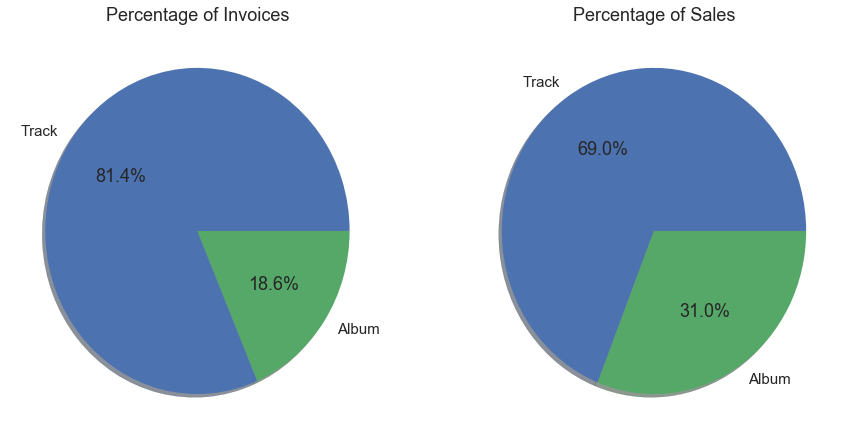

In [44]:
sns.set(font_scale=1.5)
fig = plt.figure(figsize=(15,7.5))

#Pie chart for invoice
ax = fig.add_subplot(1, 2, 1)
percent_labels = album_track['invoice_percentage']
ax = plt.pie(percent_labels, labels=['Track', 'Album'], autopct='%1.1f%%', shadow=True)
plt.title('Percentage of Invoices')
    
    
#Pie chart for sales
ax2 = fig.add_subplot(1, 2, 2)
percent_labels = album_track['sales_percentage']
ax2 = plt.pie(percent_labels, labels=['Track', 'Album'], autopct='%1.1f%%', shadow=True)
plt.title('Percentage of Sales')

plt.show()

Based on the data albums make up about 18.6% of the invoices and 31% of the sales which is significant.

# Finding the Best Selling Albums

In [48]:
query5='''
WITH invoice_detailed AS
    (SELECT
        a.album_id,
        a.title,
        t.track_id,
        i.invoice_id,
        (i.total) total
    FROM
        track t
    INNER JOIN invoice_line il ON il.track_id = t.track_id
    INNER JOIN invoice i ON i.invoice_id = il.invoice_id
    INNER JOIN album a ON a.album_id = t.album_id
    GROUP BY i.invoice_id
    ),
    
    songs AS
    (
    SELECT 
        album_id album_key,
        count(*) number_of_songs
    FROM 
        track
    GROUP BY album_key
    )
    
SELECT
    album_id,
    title,
    SUM(total),
    count(*) copies_sold,
    number_of_songs,
    CAST (SUM(total) AS FLOAT)/(number_of_songs) Revenue_per_song      
FROM 
    (
    SELECT
        ivd.*,
        CASE
            WHEN
                (
                SELECT t.track_id FROM track t 
                WHERE t.album_id = (
                                    SELECT t2.album_id FROM track t2 
                                    WHERE t2.track_id = ivd.track_id
                                    )
                EXCEPT 

                SELECT il2.track_id FROM invoice_line il2
                WHERE il2.invoice_id = ivd.invoice_id
                ) IS NULL
             AND
                (
                SELECT il2.track_id FROM invoice_line il2
                WHERE il2.invoice_id = ivd.invoice_id

                EXCEPT 

                SELECT t.track_id FROM track t
                WHERE t.album_id = (
                                    SELECT t2.album_id FROM track t2
                                    WHERE t2.track_id = ivd.track_id
                                    ) 
                ) IS NULL                                  
            THEN 'Yes'
            ELSE 'No'
        END AS 'album_purchase'
    FROM invoice_detailed ivd
    ) q
INNER JOIN songs s ON s.album_key = q.album_id 
WHERE album_purchase = 'Yes' 
GROUP BY album_id
ORDER BY copies_sold DESC
LIMIT 5
'''
album_sales = run_query(query5)
album_sales

,album_id,title,SUM(total),copies_sold,number_of_songs,Revenue_per_song
0,120,Are You Experienced?,100.98,6,17,5.94
1,119,Get Born,51.48,4,13,3.96
2,186,News Of The World,43.56,4,11,3.96
3,157,Miles Ahead,41.58,3,14,2.97
4,188,Green,32.67,3,11,2.97


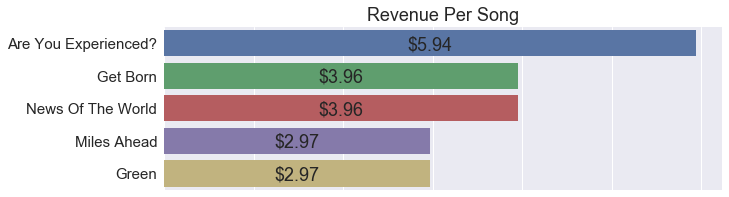

In [49]:
sns.set(font_scale=1.5)
fig = plt.figure(figsize=(10,3))

#Generate the bar plot
ax = fig.add_subplot(1, 1, 1)
ax = sns.barplot(y="title", x="Revenue_per_song", data=album_sales, palette="deep")
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_xticklabels('')
plt.title('Revenue Per Song') 

#Generate Revenue_per_song labels.
percent_labels = album_sales['Revenue_per_song']
for i in range(len(ax.patches)):
    p = ax.patches[i]
    width = p.get_width()
    ax.text(width/2,
            p.get_y()+p.get_height()-0.2,
            '$'+'{:1.2f}'.format(percent_labels.iloc[i]),
            ha="center")
plt.show()

Based on the information above 'Are You Experienced?' is the best selling album with revenue of $5.94 per song.

# Finding the Best Artists

In [56]:
query6 ='''WITH invoice_line_detailed AS
    (
    SELECT
        ar.artist_id,
        ar.name,
        il.quantity,
        il.unit_price
    FROM
        track t
    INNER JOIN invoice_line il ON il.track_id = t.track_id
    INNER JOIN album a ON a.album_id = t.album_id
    INNER JOIN artist ar ON ar.artist_id = a.artist_id
    ),

    tracks_artist AS
    (
    SELECT
        a.artist_id artist_key,
        count(*) songs_in_shop
    FROM
        track t
    INNER JOIN album a ON a.album_id = t.album_id
    INNER JOIN artist ar ON ar.artist_id = a.artist_id
    GROUP BY artist_key
    )

SELECT
    artist_id,
    name Artist,
    SUM(quantity) songs_sold,
    SUM(unit_price) revengue_generated,
    songs_in_shop,
    SUM(unit_price)/CAST (songs_in_shop AS FLOAT) revenue_per_song
FROM invoice_line_detailed ivd
INNER JOIN tracks_artist ta on ta.artist_key = ivd.artist_id 
GROUP BY name
ORDER BY revenue_per_song DESC
'''
artist_sales = run_query(query6)
top10= artist_sales.iloc[0:10]
top10

,artist_id,Artist,songs_sold,revengue_generated,songs_in_shop,revenue_per_song
0,196,Cake,31,30.69,1,30.69
1,94,Jimi Hendrix,187,185.13,17,10.89
2,253,Calexico,10,9.90,1,9.90
3,135,System Of A Down,93,92.07,11,8.37
4,240,Gustav Mahler,8,7.92,1,7.92
5,268,Itzhak Perlman,8,7.92,1,7.92
6,227,Luciano Pavarotti,8,7.92,1,7.92
7,87,Godsmack,96,95.04,12,7.92
8,120,Pink Floyd,68,67.32,9,7.48
9,140,The Doors,83,82.17,11,7.47


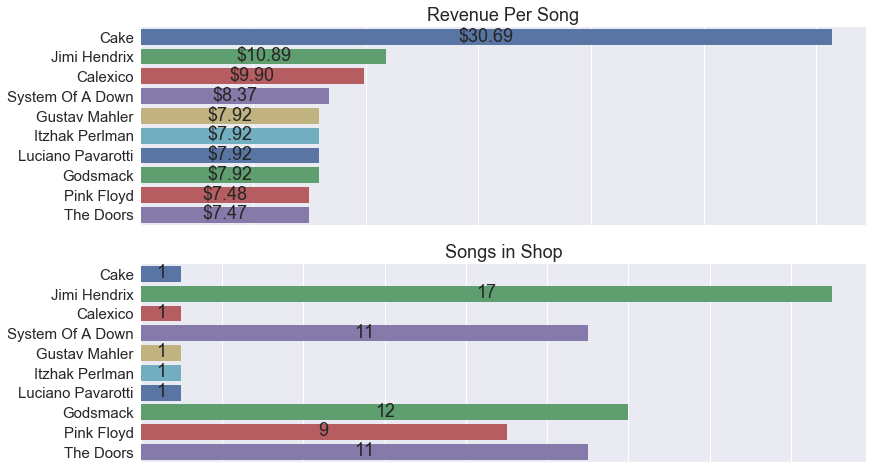

In [59]:
sns.set(font_scale=1.5)
fig = plt.figure(figsize=(13,8))


#Generate the top bar plot
ax = fig.add_subplot(2, 1, 1)
ax = sns.barplot(y="Artist", x="revenue_per_song", data=top10, palette="deep")
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_xticklabels('')
plt.title('Revenue Per Song') 

#Generate revenue_per_song labels.
labels = top10['revenue_per_song']
for i in range(len(ax.patches)):
    p = ax.patches[i]
    width = p.get_width()
    ax.text(width/2,
            p.get_y()+p.get_height()-0.2,
            '$'+'{:1.2f}'.format(labels.iloc[i]),
            ha="center")
    
#Generate the bottom bar plot
ax = fig.add_subplot(2, 1, 2)
ax = sns.barplot(y="Artist", x="songs_in_shop", data=top10, palette="deep")
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_xticklabels('')
plt.title('Songs in Shop') 

#Generate 'Songs in Shop' labels.
percent_labels = top10['songs_in_shop']
for i in range(len(ax.patches)):
    p = ax.patches[i]
    width = p.get_width()
    ax.text(width/2,
            p.get_y()+p.get_height()-0.2,
            '{:1.0f}'.format(percent_labels.iloc[i]),
            ha="center")
plt.show()

According to the data the artist 'Cake' has the highest revenue per son which is $30.69. However, 'Cake' has only one song in the whole store. 'Calexico', 'Gustav Mahler', 'Itzhak Perlman' and 'Luciano Pavarotti' too have one song each in the store, but are in the list of top 10 revenues per song. It would be useful to find more tracks from these artists to add to their store as they may be similar in popularity.